<a href="https://colab.research.google.com/github/RaghavendraGaleppa/GANs/blob/master/DCGAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as utils
import numpy as np
import matplotlib.pyplot as plt

In [0]:
manual_seed = 999
print('Random Seed: ', manual_seed)
torch.manual_seed(manual_seed)

Random Seed:  999


In [0]:
# Root directory where datasets are kept
dataroot = './.data/celeba'

# Number of workers for dataloader
workers = 2

# Batch Size
batch_size = 128

# All images resized to this size
img_size = 64

# Number of channels
nc = 3

# Size of z latent vector
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Hyper parameter for adam optimizers
beta1 = 0.5

# Number of GPU's available
ngpu = 1

In [0]:
# Link your colab to your drive and download the dataset
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Copy create the folder for the dataset and copy it
#!mkdir  ./.data
#!mkdir ./.data/celeba
!cp '/content/gdrive/My Drive/img_align_celeba.zip' ./.data/

In [0]:
!unzip -q ./.data/img_*.zip -d ./.data/celeba

replace ./.data/celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
n


In [0]:
dataset = dset.ImageFolder(root=dataroot,
                          transform = transforms.Compose([
                              transforms.Resize(img_size),
                              transforms.CenterCrop(img_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                          ]))

In [0]:
# Create the data loader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

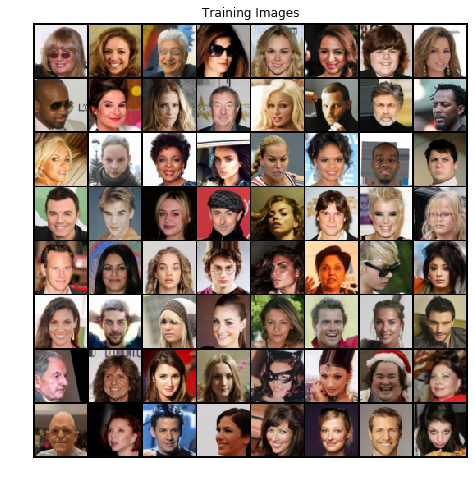

In [0]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [0]:
class Generator(nn.Module):
  
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # (bs,100,1,1) -> (bs,ngf*16,4,4)
        nn.ConvTranspose2d(nz, ngf*16, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf*16),
        nn.ReLU(True),
        
        # (bs,ngf*16,4,4) -> (bs,ngf*8,8,8)
        nn.ConvTranspose2d(ngf*16, ngf*8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(True),
        
        # (bs,ngf*8,8,8) -> (bs,ngf*4,16,16)
        nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),
        
        # (bs,ngf*4,16,16) -> (bs,ngf*2,32,32)
        nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(True),
        
        # (bs,ngf*2,32,32) -> (bs,nc,64,64)
        nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1, bias=False),
        nn.Tanh()
    )
    
  def forward(self, x):
    return self.main(x)

In [0]:
netG = Generator(ngpu).to(device)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [0]:
class Discriminator(nn.Module):
  
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        # (bs, nc, 64, 64) -> (bs, ndf, 32, 32)
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        
        # (bs, ndf, 32, 32) -> (bs, ndf*2, 16, 16)
        nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2, inplace=True),
        
        # (bs, ndf*2, 16, 16) -> (bs, ndf*4, 8, 8)
        nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2, inplace=True),
        
        # (bs, ndf*4, 8, 8) -> (bs, ndf*8, 4, 4)
        nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2, inplace=True),
        
        # (bs, ndf*8, 4, 4) -> (bs, 1, 1, 1)
        nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid(),
    )
    
  def forward(self, x):
    return self.main(x)
    
    

In [0]:
netD = Discriminator(ngpu).to(device)
netD(torch.randn(3,3,64,64, device=device)).size()
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [0]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,0.999))

In [0]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print('Start Training')

for epoch in range(num_epochs):
  for i, data in enumerate(dataloader, 0):
    # 1. Update the Discriminator
    # Train real batches
    netD.zero_grad()
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, device=device)
    output = netD(real_cpu).view(-1)
    errD_real = criterion(output,label)
    errD_real.backward()
    D_x =output.mean().item()
    
    # Train Fake batches
    noise = torch.randn(b_size,nz,1,1,device=device)
    fake = netG(noise)
    label.fill_(fake_label)
    output = netD(fake.detach()).view(-1)
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    
    # Update D
    optimizerD.step()
    
    # 2. Update Generator
    netG.zero_grad()
    label.fill_(real_label)
    output = netD(fake).view(-1)
    
    errG = criterion(output,label)
    errG.backward()
    D_G_z2 = output.mean().item()
    
    optimizerG.step()
    
    # Output training stats
    if i%50 == 0:
      print('[%d][%d][%d][%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch,num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      
    
    # Save losses
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        img_list.append(utils.make_grid(fake, padding=2, normalize=True))
    
    iters += 1
    

Start Training
[0][5][0][1583]	Loss_D: 1.3593	Loss_G: 1.4203	D(x): 0.5396	D(G(z)): 0.5193 / 0.2447
[0][5][50][1583]	Loss_D: 0.2099	Loss_G: 7.3465	D(x): 0.8465	D(G(z)): 0.0085 / 0.0011
[0][5][100][1583]	Loss_D: 1.0680	Loss_G: 2.4661	D(x): 0.6206	D(G(z)): 0.4204 / 0.0887
[0][5][150][1583]	Loss_D: 1.0262	Loss_G: 1.9183	D(x): 0.4853	D(G(z)): 0.1631 / 0.1812
[0][5][200][1583]	Loss_D: 1.1186	Loss_G: 1.8576	D(x): 0.7695	D(G(z)): 0.5402 / 0.1776
[0][5][250][1583]	Loss_D: 1.0692	Loss_G: 1.9951	D(x): 0.6610	D(G(z)): 0.4375 / 0.1628
[0][5][300][1583]	Loss_D: 0.8501	Loss_G: 1.6957	D(x): 0.5780	D(G(z)): 0.2182 / 0.2127
[0][5][350][1583]	Loss_D: 1.1520	Loss_G: 1.3767	D(x): 0.4525	D(G(z)): 0.2267 / 0.2757
[0][5][400][1583]	Loss_D: 1.0830	Loss_G: 2.1401	D(x): 0.6495	D(G(z)): 0.4386 / 0.1374
[0][5][450][1583]	Loss_D: 0.8169	Loss_G: 2.0705	D(x): 0.7195	D(G(z)): 0.3532 / 0.1440
[0][5][500][1583]	Loss_D: 1.4698	Loss_G: 2.5726	D(x): 0.6894	D(G(z)): 0.6154 / 0.0861
[0][5][550][1583]	Loss_D: 1.7881	Loss_G: 6

In [0]:
k = netG(torch.randn(1,100,1,1, device=device)).cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


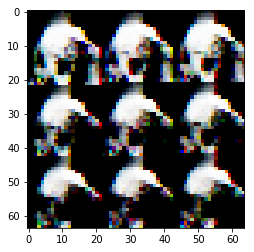

In [0]:
plt.imshow(k[0].view(64,64,3).detach().numpy())

In [0]:
plt.figure(figsize=(32,32))
k = img_list[-1]
k.shape

torch.Size([3, 530, 530])

<Figure size 2304x2304 with 0 Axes>

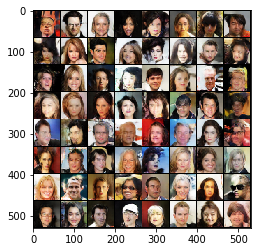

In [0]:
plt.imshow(np.transpose(k,(1,2,0)))

In [0]:
fake = netG(torch.randn(1,100,1,1,device=device)).detach().cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


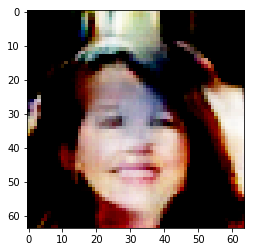

In [0]:
plt.imshow(np.transpose(fake[0],(1,2,0)))

In [0]:
torch.save(netG,'gdrive/My Drive/netG.h')


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
ni = torch.load('gdrive/My Drive/netG.h')

In [0]:
f = ni(torch.randn(1,100,1,1, device=device)).detach().cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


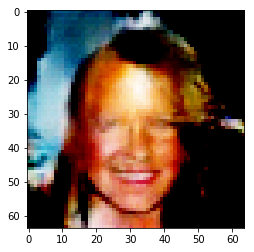

In [0]:
plt.imshow(np.transpose(f[0], (1,2,0)))

In [0]:
!ls

gdrive	sample_data
